In [ ]:
%pip install qiskit-aer
%pip install seaborn
%pip install pylatexenc


In [45]:
import numpy as np
from quam_libs.components import QuAM, TransmonPair
from quam_libs.experiments.two_qubit_xeb import (
    XEBConfig,
    XEB,
    backend as fake_backend,
    QUAGate,
)

machine = QuAM.load()
qubits = machine.active_qubits
# Get the relevant QuAM components
readout_qubit_indices = [0,1,2,3,4]  # Indices of the target qubits
readout_qubits = [qubits[i] for i in readout_qubit_indices]
target_qubit_indices = [4]  # Indices of the target qubits
target_qubits = [qubits[i] for i in target_qubit_indices]
target_qubit_pairs = [
    qubit_pair
    for qubit_pair in machine.active_qubit_pairs
    if qubit_pair.qubit_control in target_qubits and qubit_pair.qubit_target in target_qubits

]

print("target_qubits: %s" %[q.name for q in target_qubits]) 


def cz_gate(qubit_pair: TransmonPair):
    """
    CZ gate QUA macro: Add your own QUA code here implementing your CZ gate for any given qubit pair
    :param qubit_pair: TransmonPair instance on which to apply the gate
    :return: None
    """

    pass


cz_qua = QUAGate("cz", cz_gate)

xeb_config = XEBConfig(
    seqs=60, #81,
    # depths=np.arange(1, 1200, 24),
    depths=np.arange(1, 550, 10),
    n_shots=700, #1000,
    readout_qubits=readout_qubits, 
    qubits=target_qubits,
    qubit_pairs=target_qubit_pairs,
    baseline_gate_name="x90",
    gate_set_choice="sw",
    two_qb_gate=None, #cz_qua,
    save_dir="",
    should_save_data=False, #True,
    generate_new_data=True,
    disjoint_processing=False, #False,
    # reset_method="active",
    # reset_kwargs={"max_tries": 3, "pi_pulse": "x180"},
    reset_method="cooldown", #"active",
    reset_kwargs={"cooldown_time": 100000, "max_tries": 3, "pi_pulse": "x180"},
)

simulate = False  # Set to True to simulate the experiment with Qiskit Aer instead of running it on the QPU
xeb = XEB(xeb_config, quam=machine)
if simulate:
    job = xeb.simulate(backend=fake_backend)
else:
    job = xeb.run(simulate=False)  # If simulate is False, job is run on the QPU, else pulse output is simulated

# 87 * 500/12 * 1000 = 13m 26.8s 
# 87 * 1200/24 * 700 = 22m 42.3s


target_qubits: ['q5']
2024-11-10 23:32:56,628 - qm - INFO     - Performing health check
2024-11-10 23:32:56,640 - qm - INFO     - Cluster healthcheck completed successfully.


/Users/adamachuck/Documents/GitHub/ASQUM/qua-libs/Quantum-Control-Applications-QuAM/Superconducting/quam_libs/experiments/two_qubit_xeb/xeb.py:53: UserWarning: No qubit pairs provided. The experiment will run with single qubit gates only.
  warn("No qubit pairs provided. The experiment will run with single qubit gates only.")


2024-11-10 23:32:58,807 - qm - INFO     - Adding program to queue.


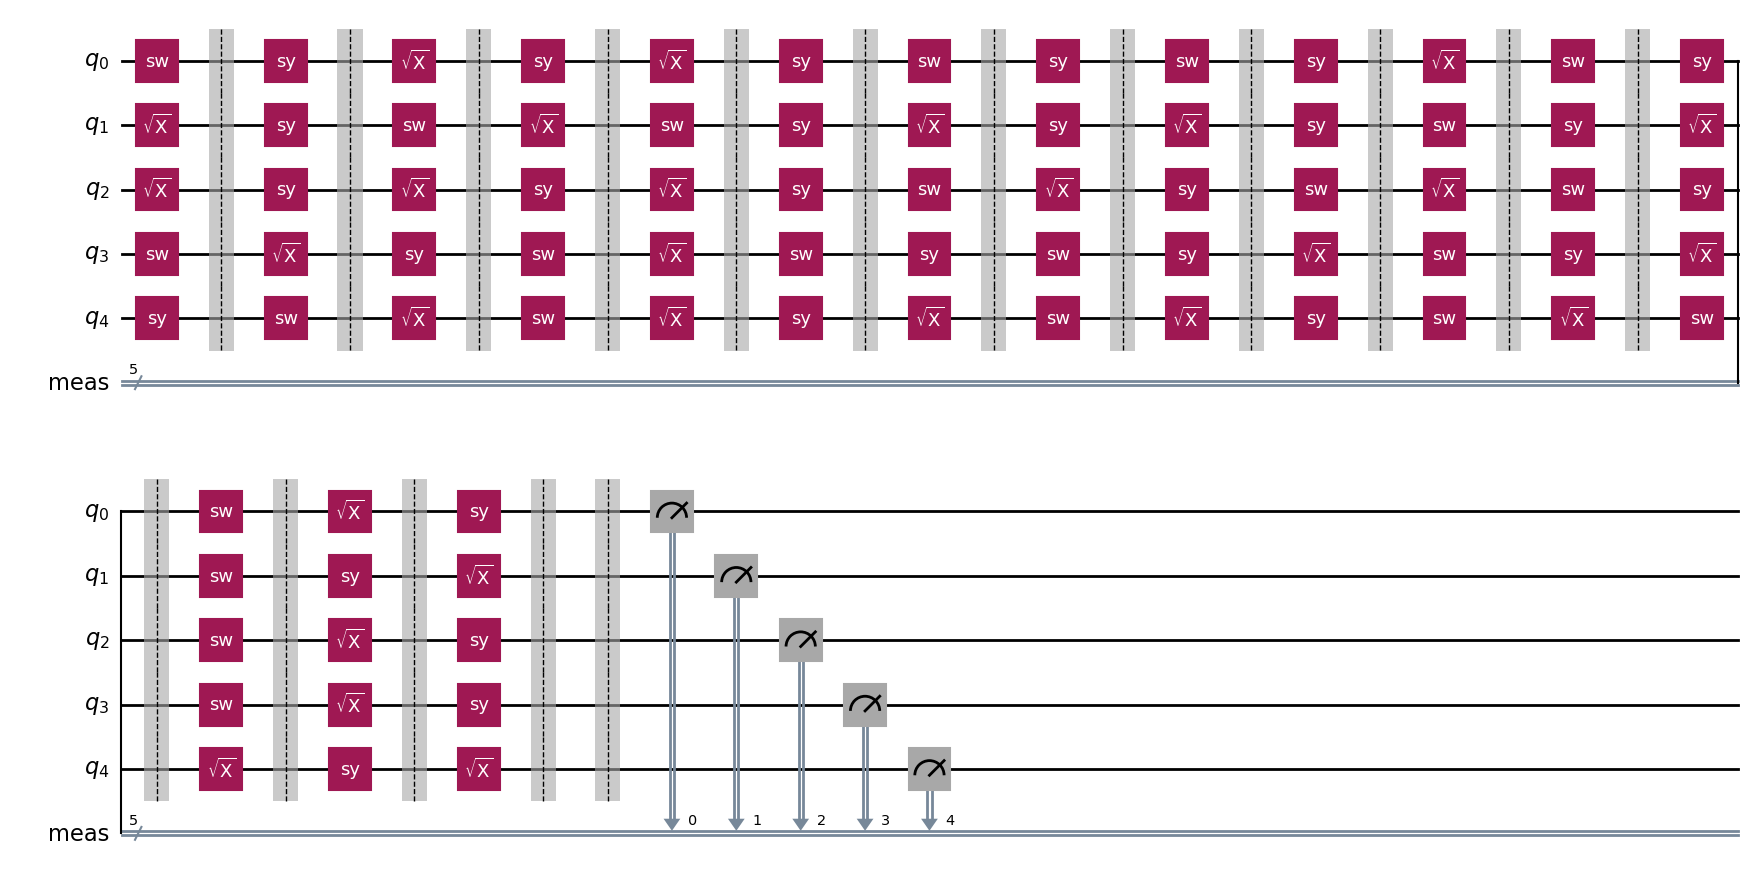

In [14]:
job.circuits[7][3].draw("mpl") # job.circuits[seq][depth] 

In [ ]:
job.circuits[7][9].draw("mpl") # job.circuits[seq][depth]

/Users/adamachuck/Documents/GitHub/ASQUM/qua-libs/Quantum-Control-Applications-QuAM/Superconducting/quam_libs/experiments/two_qubit_xeb/xeb.py:685: RuntimeWarning: invalid value encountered in scalar divide
  f_xeb = (xe_incoherent - xe_measured) / (xe_incoherent - xe_expected)
/Users/adamachuck/Documents/GitHub/ASQUM/qua-libs/Quantum-Control-Applications-QuAM/Superconducting/quam_libs/experiments/two_qubit_xeb/xeb.py:685: RuntimeWarning: divide by zero encountered in scalar divide
  f_xeb = (xe_incoherent - xe_measured) / (xe_incoherent - xe_expected)
/Users/adamachuck/Documents/GitHub/ASQUM/qua-libs/Quantum-Control-Applications-QuAM/Superconducting/quam_libs/experiments/two_qubit_xeb/xeb.py:737: RuntimeWarning: invalid value encountered in scalar divide
  fid_lsq = df["numerator"].sum() / df["denominator"].sum()


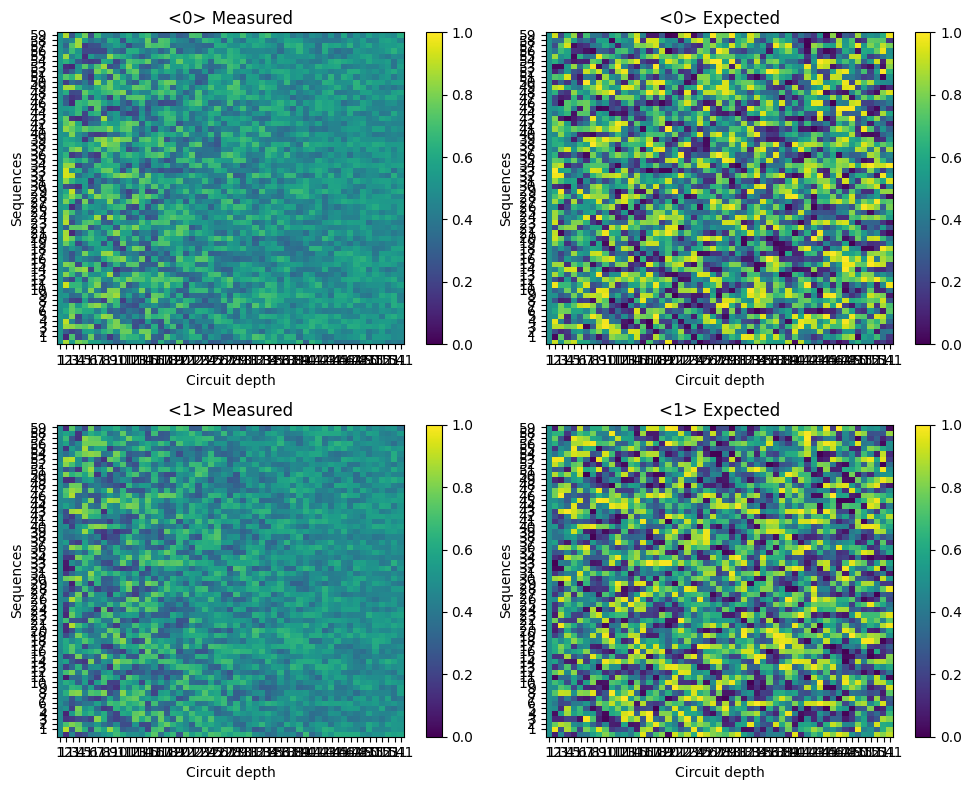

In [46]:
# 1. Extracting Outputs from QPU (QUA, Measured) 
# 2. Extracting recorded Circuits and perform ideal simulation accordingly on CPU (Expected): 
result = job.result()
result.plot_state_heatmap()

In [ ]:
xeb.qubits

/Users/adamachuck/Documents/GitHub/ASQUM/qua-libs/Quantum-Control-Applications-QuAM/Superconducting/quam_libs/experiments/two_qubit_xeb/xeb.py:922: RuntimeWarning: invalid value encountered in scalar divide
  fid_lsq = df["numerator"].sum() / df["denominator"].sum()


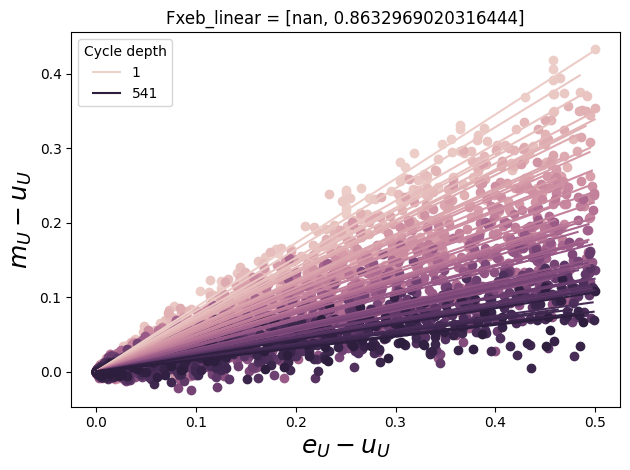

In [47]:
# Compute Fidelities:  
result.plot_records()


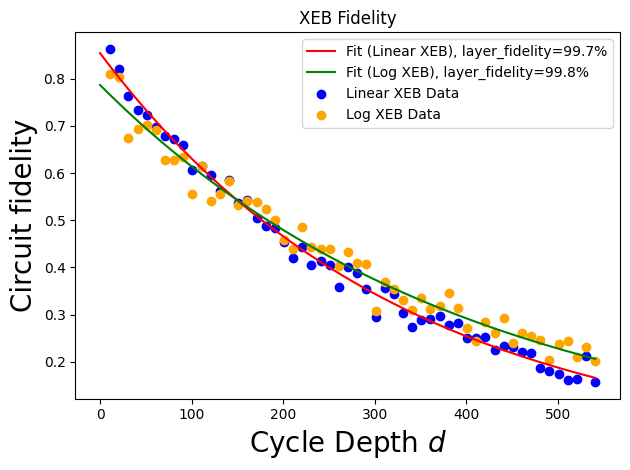

In [51]:
result.plot_fidelities()

In [54]:
# Debugging:  
print(xeb.xeb_config.qubit_pairs)

# print(result.saved_data)
print("Singularities: %s%%" % (len(result.singularities) / xeb_config.seqs * 100) )
print(result.singularities)
      
# print("['counts']['0']: ")
# print(result.saved_data['counts']['0'])

# print("['counts']['1']: ")
# print(result.saved_data['counts']['1'])


[]
Singularities: 103.33333333333334%
[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 0), (35, 0), (36, 0), (37, 0), (38, 0), (39, 0), (40, 0), (41, 0), (42, 0), (43, 0), (44, 0), (45, 0), (45, 1), (46, 0), (47, 0), (48, 0), (49, 0), (50, 0), (51, 0), (52, 0), (53, 0), (54, 0), (55, 0), (55, 2), (56, 0), (57, 0), (58, 0), (59, 0)]


In [ ]:
print([readout.operations["readout"].threshold for readout in xeb.readout_channels])

In [8]:
list(xeb.coupling_map.get_edges())

[(0, 2)]

In [ ]:
# result.saved_data["states"]
result.saved_data["amp_matrix_q0"]